# Amazon Fine Food Reviews Analysis- sentimental analysis using KNN Classifier

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon. Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10 Attribute Information: 1) Id 2) ProductId - unique identifier for the product 3) UserId - unqiue identifier for the user 4) ProfileName 5) HelpfulnessNumerator - number of users who found the review helpful 6) HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not 7) Score - rating between 1 and 5 8) Time - timestamp for the review 9) Summary - brief summary of the review 10) Text - text of the review Objective: Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).
[Q] How to determine if a review is positive or negative? [Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review. 

Loading the data The dataset is available in two forms 1).csv file 2)SQLite Database In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".
we will make postive label as 1 and negative score as 0 becoz we are taking F1_score as metric.

In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import gensim
import re
import nltk
import matplotlib.pyplot as plt
from  nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



# Any results you write to the current directory are saved as output.

In [4]:
data = pd.read_pickle("final_data.pkl")
data.shape

(100000, 11)

***Loading the data using sqlite*******

In [3]:
con = sqlite3.connect("../input/database.sqlite")
data = pd.read_sql_query('select * from reviews where Score !=3',con)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Data preprocessing**

In [4]:
#changing reviews score to postive if score is > 3 and negative if score less than 3

def change_labels(x):
    if x > 3:
        return 1
    return 0
temp_score = data['Score']
temp_score = temp_score.map(change_labels)
data['Score'] =  temp_score
data['Score'].head()

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

**Data Cleanising**

In [5]:
#Removing Duplicates
print('Number of data points before removing duplicates',data.shape[0])
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
clean_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print('Number of data points after removing duplicates',clean_data.shape[0])

Number of data points before removing duplicates 525814
Number of data points after removing duplicates 364173


In [6]:
#removing rows whihch has HelpfulnessNumerator greater than HelpfulnessDenominator
clean_data=clean_data[clean_data['HelpfulnessNumerator']<=clean_data['HelpfulnessDenominator']]
print('Now the Number of data points are',clean_data.shape[0])

Now the Number of data points are 364171


looks like there are only 3 rows with HelpfulnessNumerator greater than HelpfulnessDenominator . Thats great !!
Now lets go to the intresting part where we will clean the text reviews

In [7]:
#lets define some functions to  clean the reviews

#to remove HTML Tags
def clean_html(x):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', x)
    return cleantext
#  to remove unwanted charecteres like '!',',' etc.

def cleansen(x):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',x)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

#stop words

stop_words = set(stopwords.words('english'))
#intialising stremming
stemmer = nltk.stem.SnowballStemmer('english')


In [8]:
import datetime

str1=' '
final_string=[]

s=''
start_time = datetime.datetime.now()
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    sent=clean_html(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleansen(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop_words):
                    s=(stemmer.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
clean_data['CleanedText']=final_string
print('Total time taken to clean the reviews',datetime.datetime.now()-start_time)

    

Total time taken to clean the reviews 0:04:39.597683


In [9]:
clean_data['CleanedText'].head()

138706    b'witti littl book make son laugh loud recit c...
138688    b'grew read sendak book watch realli rosi movi...
138689    b'fun way children learn month year learn poem...
138690    b'great littl book read nice rhythm well good ...
138691    b'book poetri month year goe month cute littl ...
Name: CleanedText, dtype: object

In [10]:
#lets take 100k points 
final_data = clean_data.head(100000)
final_data.shape

(100000, 11)


Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively****

In [11]:
#noe lets split the data 
from sklearn.model_selection import train_test_split
x,x_test,y,y_test = train_test_split(final_data['CleanedText'],final_data['Score'],train_size=0.8)
x_train,x_cv,y_train,y_cv = train_test_split(x,y,train_size=0.8)


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


**Bag of Words (BoW)** A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.

In [12]:
#Lets Vecotirize
#bagof words
bag_words = CountVectorizer()
x_train_bag= bag_words.fit_transform(x_train)
x_test_bag= bag_words.transform(x_test)
x_cv_bag= bag_words.transform(x_cv)

print('After vectorizing shape of x Train',x_train_bag.shape)
print('After vectorizing shape of x Test',x_test_bag.shape)
print('After vectorizing shape of x CV',x_cv_bag.shape)

After vectorizing shape of x Train (64000, 30264)
After vectorizing shape of x Test (20000, 30264)
After vectorizing shape of x CV (16000, 30264)


# KNN Classifier
Classifier implementing the k-nearest neighbors vote.Here will be will be implemeting using two Algoithms
1) Brute
2) KD_Tree

In [6]:
from sklearn.preprocessing import StandardScaler
def knn_brute(x_train,y_train,x_test,y_test,x_cv,y_cv):
    
    k = [i for i in range(1,40,5)]
    
    cv_f1_score_array=[]
    train_f1_score_array=[]
    stan = StandardScaler(with_mean = False)
    x_train = stan.fit_transform(x_train)
    x_cv = stan.transform(x_cv)
    for n  in k:
        
        clf = KNeighborsClassifier(n_neighbors = n,algorithm='brute' )
        clf.fit(x_train,y_train)
        predict_y = clf.predict(x_cv)
        predict_y_t = clf.predict(x_train)
        cv_f1_score_array.append(f1_score(y_cv, predict_y))
        train_f1_score_array.append(f1_score(y_train, predict_y_t))
        print('For values of k = ', n, "The f1 score is:",f1_score(y_cv, predict_y))
    fig, ax = plt.subplots()
    ax.plot(k, train_f1_score_array,c='b',label ='Train f1_score' )
    for i, txt in enumerate(np.round(train_f1_score_array,2)):
        ax.annotate((k[i],np.round(txt,2)), (k[i],train_f1_score_array[i]))
    ax.plot(k, cv_f1_score_array,c='g',label ='test f1_score')
    for i, txt in enumerate(np.round(cv_f1_score_array,2)):
        ax.annotate((k[i],np.round(txt,2)), (k[i],cv_f1_score_array[i]))
    plt.grid()
    
    plt.title("f1 score for each K ")
    plt.xlabel("K neighbors's")
    plt.ylabel("f1_Score")
    plt.legend()
    plt.show()
def knn_kdtree(x_train,y_train,x_test,y_test,x_cv,y_cv):
    
    k = [i for i in range(1,40,6)]
    
    cv_f1_score_array=[]
    train_f1_score_array=[]
    for n  in k:
        
        clf = KNeighborsClassifier(n_neighbors = n,algorithm='kd_tree' )
        clf.fit(x_train,y_train)
        predict_y = clf.predict(x_cv)
        predict_y_t = clf.predict(x_train)
        cv_f1_score_array.append(f1_score(y_cv, predict_y))
        train_f1_score_array.append(f1_score(y_train, predict_y_t))
        print('For values of k = ', n, "The f1 score is:",f1_score(y_cv, predict_y))
    fig, ax = plt.subplots()
    ax.plot(k, train_f1_score_array,c='b',label ='Train logg error' )
    for i, txt in enumerate(np.round(train_f1_score_array,2)):
        ax.annotate((k[i],np.round(txt,2)), (k[i],train_f1_score_array[i]))
    ax.plot(k, cv_f1_score_array,c='g',label ='CV logg error')
    for i, txt in enumerate(np.round(cv_f1_score_array,2)):
        ax.annotate((k[i],np.round(txt,2)), (k[i],cv_f1_score_array[i]))
    plt.grid()
    
    plt.title("f1 score for each K ")
    plt.xlabel("K neighbors's")
    plt.ylabel("f1_Score")
    plt.legend()
    plt.show()

In [7]:
import seaborn as sns

def best_knn_kdtree(x_train,y_train,x_test,y_test,x_cv,y_cv,best_k):
    clf_bag_best = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree' )
    clf_bag_best.fit(x_train, y_train)
    predict_y_train = clf_bag_best.predict(x_train)
    print('For values of best k = ', best_k, "The train f_1score is:",f1_score(y_train, predict_y_train))
    predict_y_test = clf_bag_best.predict(x_test)
    print('For values of best k = ', best_k, "The test f1_score is:",f1_score(y_test,predict_y_test))
    acc_t = accuracy_score(y_train,predict_y_train)
    print('Accuracy on train data is ',acc_t)
    
    acc = accuracy_score(y_test,predict_y_test)
    print('Accuracy on test data is ',acc)
    c_1 = confusion_matrix(y_train, predict_y_train)
    C = confusion_matrix(y_test, predict_y_test)
    print("-"*20, "Confusion matrix on train data", "-"*20)
    plt.figure(figsize=(20,7))
    
    sns.heatmap(c_1, annot=True, cmap="YlGnBu", fmt="d")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Confusion matrix on test data", "-"*20)
    plt.figure(figsize=(20,7))
    
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print(classification_report(y_test, predict_y_test))
    return acc,acc_t,best_k

In [8]:
def best_knn(x_train,y_train,x_test,y_test,x_cv,y_cv,best_k):
    clf_bag_best = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute' )
    clf_bag_best.fit(x_train, y_train)
    predict_y_train = clf_bag_best.predict(x_train)
    print('For values of best k = ', best_k, "The train f_1score is:",f1_score(y_train, predict_y_train))
    predict_y_test = clf_bag_best.predict(x_test)
    print('For values of best k = ', best_k, "The test f1_score is:",f1_score(y_test,predict_y_test))
    acc_t = accuracy_score(y_train,predict_y_train)
    print('Accuracy on train data is ',acc_t)
    
    acc = accuracy_score(y_test,predict_y_test)
    print('Accuracy on test data is ',acc)
    c_1 = confusion_matrix(y_train, predict_y_train)
    C = confusion_matrix(y_test, predict_y_test)
    print("-"*20, "Confusion matrix on train data", "-"*20)
    plt.figure(figsize=(20,7))
    
    sns.heatmap(c_1, annot=True, cmap="YlGnBu", fmt="d")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Confusion matrix on test data", "-"*20)
    plt.figure(figsize=(20,7))
    
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print(classification_report(y_test, predict_y_test))
    return acc,acc_t,best_k

# Brute

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


For values of k =  1 The f1 score is: 0.8901534250522221
For values of k =  6 The f1 score is: 0.9198300576836724
For values of k =  11 The f1 score is: 0.9215726217152169
For values of k =  16 The f1 score is: 0.920813559322034
For values of k =  21 The f1 score is: 0.9202300405953991
For values of k =  26 The f1 score is: 0.9197781385281385
For values of k =  31 The f1 score is: 0.9193793732887131
For values of k =  36 The f1 score is: 0.9194943896174125


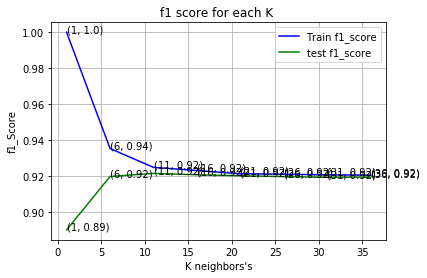

In [20]:
knn_brute(x_train_bag,y_train,x_test_bag,y_test,x_cv_bag,y_cv)

Seeing above plot we are can take K values as 11 as there is nout much difference in train and CV Scores

For values of best k =  11 The train f_1score is: 0.9244568264052865
For values of best k =  11 The test f1_score is: 0.9218741516911885
Accuracy on train data is  0.86103125
Accuracy on test data is  0.8561
-------------------- Confusion matrix on train data --------------------


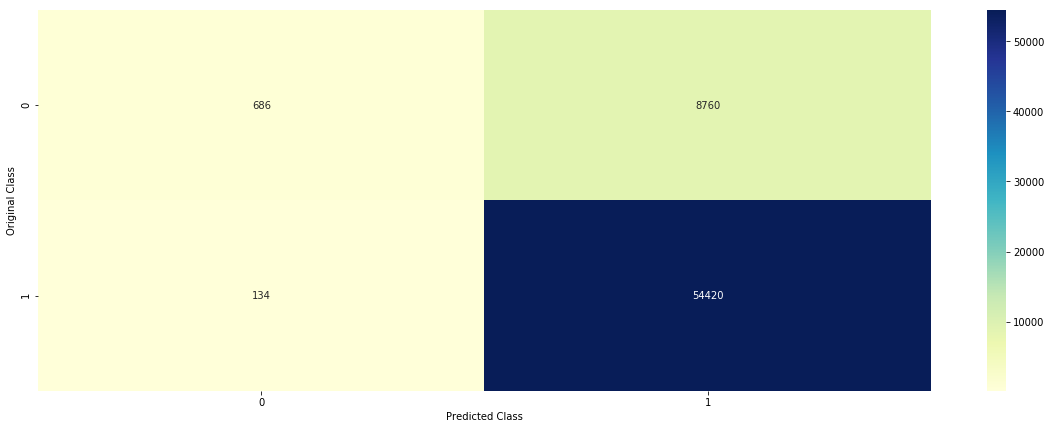

-------------------- Confusion matrix on test data --------------------


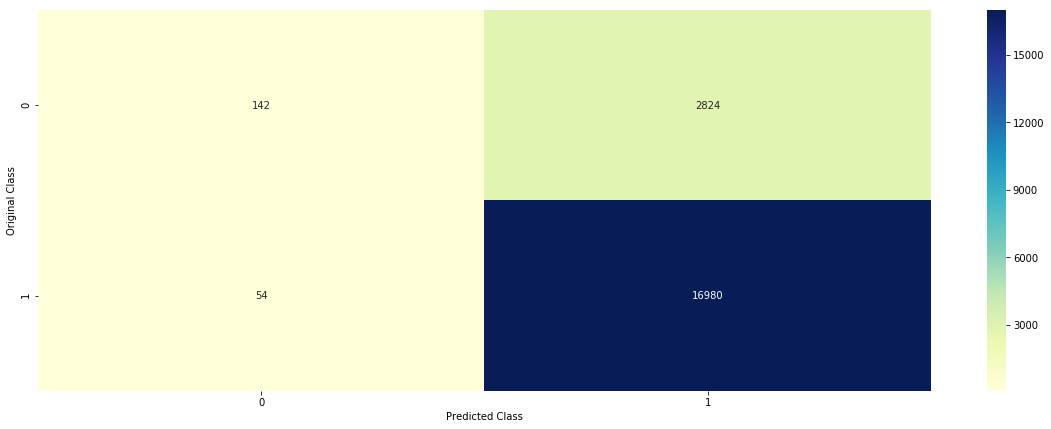

              precision    recall  f1-score   support

           0       0.72      0.05      0.09      2966
           1       0.86      1.00      0.92     17034

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.79      0.52      0.51     20000
weighted avg       0.84      0.86      0.80     20000



In [21]:
acc_bag_brute,acc_bagtest_brute,bestk_bag_brute=best_knn(x_train_bag,y_train,x_test_bag,y_test,x_cv_bag,y_cv,11)

we are getting 85% accuracy on test data. As we know that data imbalanced and Knn will be biased to majority class we are getting model slightly baised to postive points

# Tf-Idf

In [22]:
#Now Tsne
#Lets Vecotirize
#bagof words
tfidf_words = TfidfVectorizer()
x_train_tfidf= tfidf_words.fit_transform(x_train)
x_test_tfidf= tfidf_words.transform(x_test)
x_cv_tfidf= tfidf_words.transform(x_cv)
print('After vectorizing shape of x Train',x_train_tfidf.shape)
print('After vectorizing shape of x Test',x_test_tfidf.shape)
print('After vectorizing shape of x CV',x_cv_tfidf.shape)

After vectorizing shape of x Train (64000, 30264)
After vectorizing shape of x Test (20000, 30264)
After vectorizing shape of x CV (16000, 30264)


For values of k =  1 The f1 score is: 0.8933705213473504
For values of k =  6 The f1 score is: 0.918863332533507
For values of k =  11 The f1 score is: 0.9199485722019218
For values of k =  16 The f1 score is: 0.9199296679515792
For values of k =  21 The f1 score is: 0.9194905233284908
For values of k =  26 The f1 score is: 0.9193352249695987
For values of k =  31 The f1 score is: 0.9192420711318269
For values of k =  36 The f1 score is: 0.9192110240475547


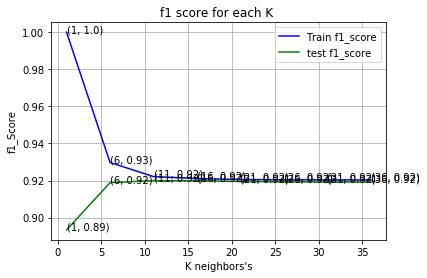

In [23]:
 knn_brute(x_train_tfidf,y_train,x_test_tfidf,y_test,x_cv_tfidf,y_cv)

from above plot we can take k as 16

For values of best k =  16 The train f_1score is: 0.930909778117564
For values of best k =  16 The test f1_score is: 0.9275632928771487
Accuracy on train data is  0.874328125
Accuracy on test data is  0.8681
-------------------- Confusion matrix on train data --------------------


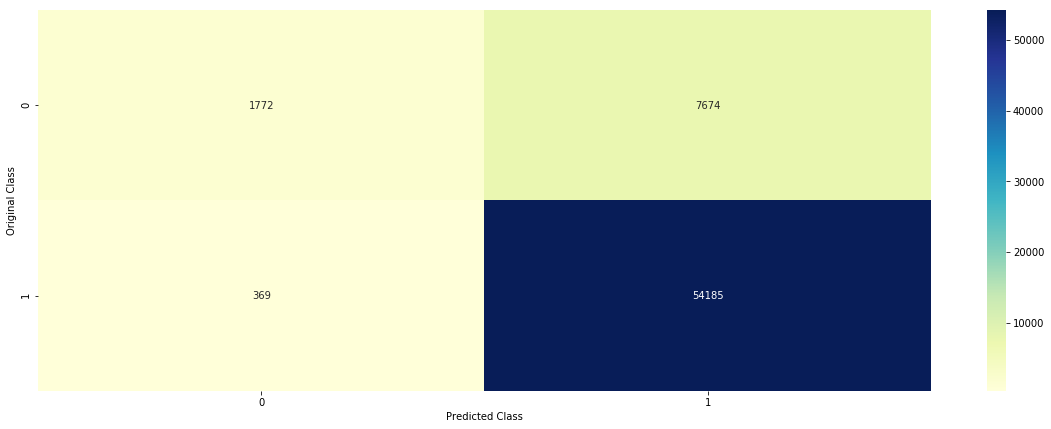

-------------------- Confusion matrix on test data --------------------


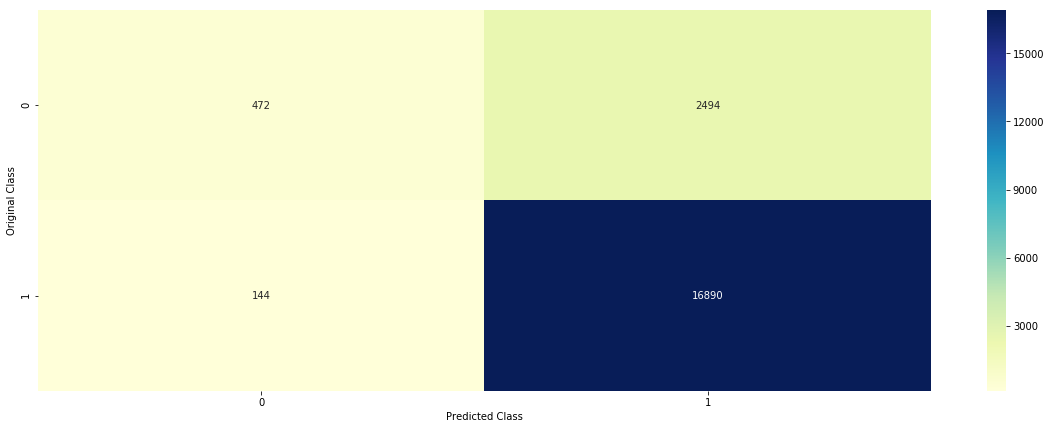

              precision    recall  f1-score   support

           0       0.77      0.16      0.26      2966
           1       0.87      0.99      0.93     17034

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.82      0.58      0.60     20000
weighted avg       0.86      0.87      0.83     20000



(0.8681, 0.874328125, 16)

In [24]:
best_knn(x_train_tfidf,y_train,x_test_tfidf,y_test,x_cv_tfidf,y_cv,16)

we are getting good accuracy than BOW

**Avg Word2Vec** One of the most naive but good ways to convert a sentence into a vector Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence

In [25]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [27]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_sent_train=[]
for sent in x_train:
    filtered_sentence=[]
    sent = sent.decode("utf-8")
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_train.append(filtered_sentence)

In [28]:
w2v_model=gensim.models.Word2Vec(list_sent_train,min_count=5,size=50, workers=4)

In [32]:
x_train_avgw2v= []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    x_train_avgw2v.append(sent_vec)
print(len(x_train_avgw2v))
print(len(x_train_avgw2v[0]))

64000
50


In [29]:
list_sent_test=[]
for sent in x_test:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=clean_html(sent)
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_test.append(filtered_sentence)
x_test_avgw2v= []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    x_test_avgw2v.append(sent_vec)
print(len(x_test_avgw2v))
print(len(x_test_avgw2v[0]))

20000
50


In [30]:
list_sent_cv=[]
for sent in x_cv:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=clean_html(sent)
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_cv.append(filtered_sentence)
x_cv_avgw2v= []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    x_cv_avgw2v.append(sent_vec)
print(len(x_cv_avgw2v))
print(len(x_cv_avgw2v[0]))

16000
50


For values of k =  1 The f1 score is: 0.9118832371201394
For values of k =  6 The f1 score is: 0.930302487918382
For values of k =  11 The f1 score is: 0.9332866888228092
For values of k =  16 The f1 score is: 0.9341519031748816
For values of k =  21 The f1 score is: 0.9340391446681062
For values of k =  26 The f1 score is: 0.9332124298120181
For values of k =  31 The f1 score is: 0.9332916623259367
For values of k =  36 The f1 score is: 0.9332962370452806


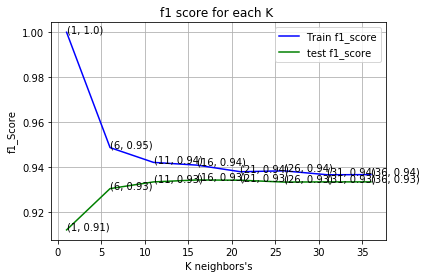

In [33]:
knn_brute(x_train_avgw2v,y_train,x_test_avgw2v,y_test,x_cv_avgw2v,y_cv)

seeing above plot , we can take k as 26

For values of best k =  26 The train f_1score is: 0.9377656239113774
For values of best k =  26 The test f1_score is: 0.9337302470509682
Accuracy on train data is  0.88834375
Accuracy on test data is  0.8809
-------------------- Confusion matrix on train data --------------------


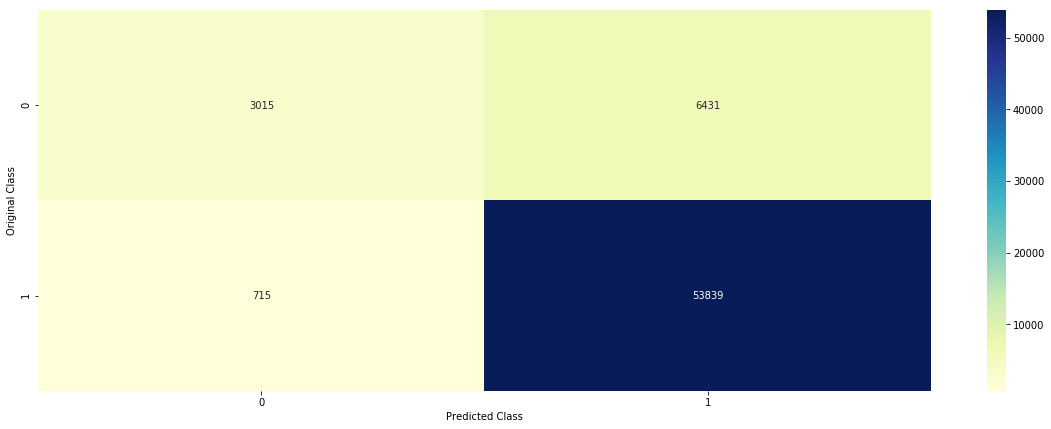

-------------------- Confusion matrix on test data --------------------


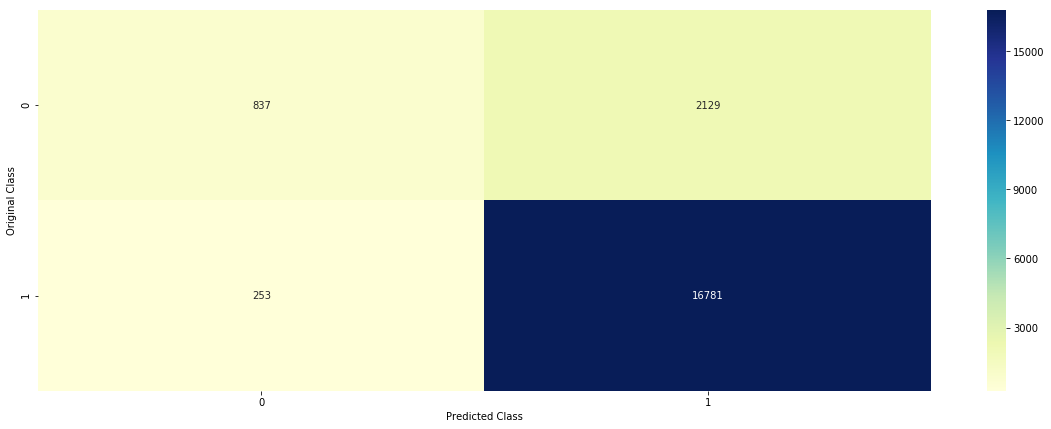

              precision    recall  f1-score   support

           0       0.77      0.28      0.41      2966
           1       0.89      0.99      0.93     17034

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.83      0.63      0.67     20000
weighted avg       0.87      0.88      0.86     20000



(0.8809, 0.88834375, 26)

In [34]:
best_knn(x_train_avgw2v,y_train,x_test_avgw2v,y_test,x_cv_avgw2v,y_cv,26)

Getting good accuracy than tfidf and BOW . model is also less biased 


**Tf-idf W2Vec** Another way to covert sentence into vectors Take weighted sum of the vectors divided by the sum of all the tfidf's i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [35]:
tfidf_feat = tfidf_words.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_train_tfidfwv= []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    x_train_tfidfwv.append(sent_vec)
    row += 1
print('train shape',len(x_train_tfidfwv),len(x_train_tfidfwv[0]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


train shape 64000 50


In [36]:
x_test_tfidfwv= []
for sent in list_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    x_test_tfidfwv.append(sent_vec)
    row += 1
print('test shape',len(x_test_tfidfwv),len(x_test_tfidfwv[0]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


test shape 20000 50


In [37]:
x_cv_tfidfwv= []
for sent in list_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    x_cv_tfidfwv.append(sent_vec)
    row += 1
print('test shape',len(x_cv_tfidfwv),len(x_cv_tfidfwv[0]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


test shape 16000 50


In [38]:
x_train_tfidfwv = np.nan_to_num(x_train_tfidfwv)
x_cv_tfidfwv = np.nan_to_num(x_cv_tfidfwv)
x_test_tfidfwv = np.nan_to_num(x_test_tfidfwv)

For values of k =  1 The f1 score is: 0.9192475260900401
For values of k =  6 The f1 score is: 0.9192475260900401
For values of k =  11 The f1 score is: 0.9192475260900401
For values of k =  16 The f1 score is: 0.9192475260900401
For values of k =  21 The f1 score is: 0.9192475260900401
For values of k =  26 The f1 score is: 0.9192475260900401
For values of k =  31 The f1 score is: 0.9192475260900401
For values of k =  36 The f1 score is: 0.9192475260900401


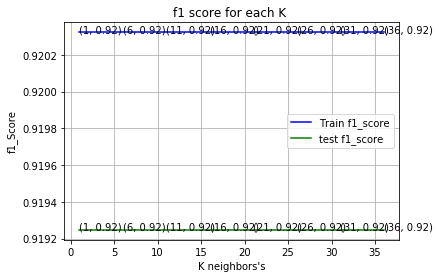

In [39]:
knn_brute(x_train_tfidfwv,y_train,x_test_tfidfwv,y_test,x_cv_tfidfwv,y_cv)

for all values of k we are getting same train and CV score .lets take k as 21

For values of best k =  21 The train f_1score is: 0.9203232282335476
For values of best k =  21 The test f1_score is: 0.9199114327374844
Accuracy on train data is  0.85240625
Accuracy on test data is  0.8517
-------------------- Confusion matrix on train data --------------------


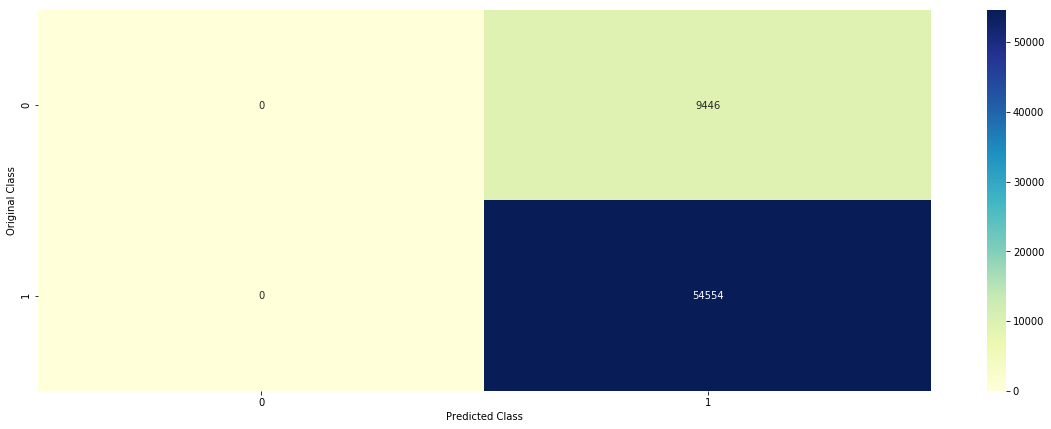

-------------------- Confusion matrix on test data --------------------


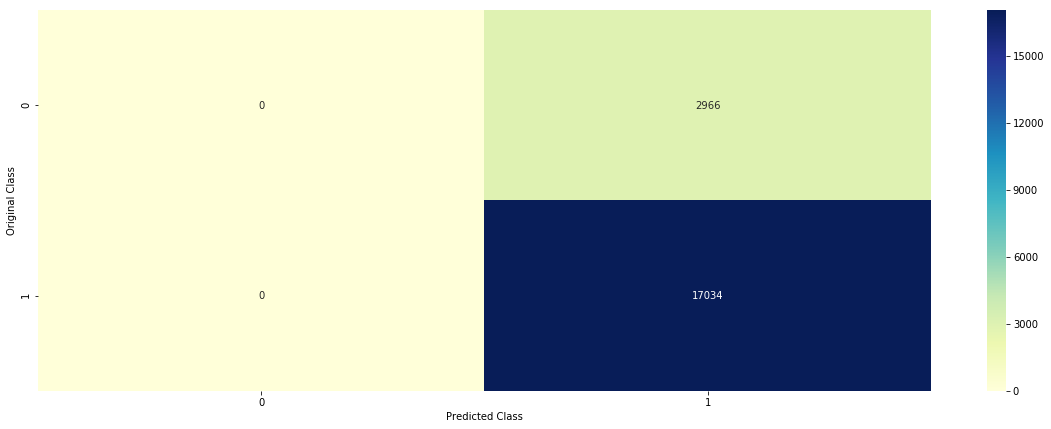

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2966
           1       0.85      1.00      0.92     17034

   micro avg       0.85      0.85      0.85     20000
   macro avg       0.43      0.50      0.46     20000
weighted avg       0.73      0.85      0.78     20000



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.8517, 0.85240625, 21)

In [40]:
best_knn(x_train_tfidfwv,y_train,x_test_tfidfwv,y_test,x_cv_tfidfwv,y_cv,21)

Model is dumb as predicntg all points as positive

# KD Tree

taking top 20k points 

In [41]:
sample_data = clean_data.head(20000)
sample_data.shape

(20000, 11)

In [9]:
#noe lets split the data 
from sklearn.model_selection import train_test_split
x_s,x_test_s,y_s,y_test_s = train_test_split(sample_data['CleanedText'],sample_data['Score'],train_size=0.8)
x_train_s,x_cv_s,y_train_s,y_cv_s = train_test_split(x_s,y_s,train_size=0.8)


/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
Bag of Words

In [10]:
bag_words_con = CountVectorizer(max_features=2000,min_df=50)
x_train_bag_c= bag_words_con.fit_transform(x_train_s)
x_test_bag_c= bag_words_con.transform(x_test_s)
x_cv_bag_c= bag_words_con.transform(x_cv_s)
print('After vectorizing with 2000 features shape of x Train',x_train_bag_c.shape)
print('After vectorizing with 2000 features shape of x Test',x_test_bag_c.shape)
print('After vectorizing with 2000 features shape of x CV',x_cv_bag_c.shape)


After vectorizing with 2000 features shape of x Train (12800, 1309)
After vectorizing with 2000 features shape of x Test (4000, 1309)
After vectorizing with 2000 features shape of x CV (3200, 1309)


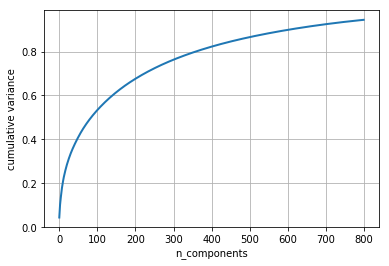

In [11]:
#converting to dense matrix using SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=800)
svd.fit_transform(x_train_bag_c)
percentage_var_explained = svd.explained_variance_ratio_
cum_var_explained = np.cumsum(percentage_var_explained)
plt.figure(1,figsize=(6,4))
plt.clf()
plt.plot(cum_var_explained,linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('cumulative variance')
plt.show()

from above plot we can see taking n_componets we are keeping more than 80% information. so taking n_components as 400

In [12]:
svd_final = TruncatedSVD(n_components=400)
x_train_bag_c = svd_final.fit_transform(x_train_bag_c)

x_test_bag_c = svd_final.transform(x_test_bag_c)

x_cv_bag_c = svd_final.transform(x_cv_bag_c)


In [ ]:
standardizing the data

In [13]:
from sklearn.preprocessing import StandardScaler
stand  = StandardScaler()
x_train_bag_c = stand.fit_transform(x_train_bag_c)

x_test_bag_c = stand.transform(x_test_bag_c)

x_cv_bag_c = stand.transform(x_cv_bag_c)


For values of k =  1 The f1 score is: 0.8717002030644267
For values of k =  7 The f1 score is: 0.9170948955121617
For values of k =  13 The f1 score is: 0.9175870858113849
For values of k =  19 The f1 score is: 0.9164402173913044
For values of k =  25 The f1 score is: 0.9158751696065129
For values of k =  31 The f1 score is: 0.9160590130574868
For values of k =  37 The f1 score is: 0.916271186440678


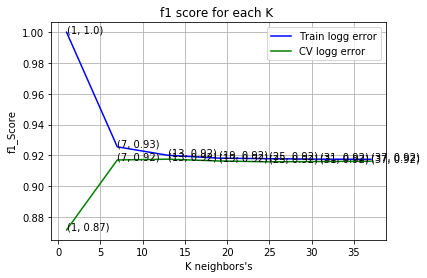

In [14]:
knn_kdtree(x_train_bag_c,y_train_s,x_test_bag_c,y_test_s,x_cv_bag_c,y_cv_s)

Taking K as 13

For values of best k =  13 The train f_1score is: 0.9223971515593495
For values of best k =  13 The test f1_score is: 0.9167695050047993
Accuracy on train data is  0.858671875
Accuracy on test data is  0.84825
-------------------- Confusion matrix on train data --------------------


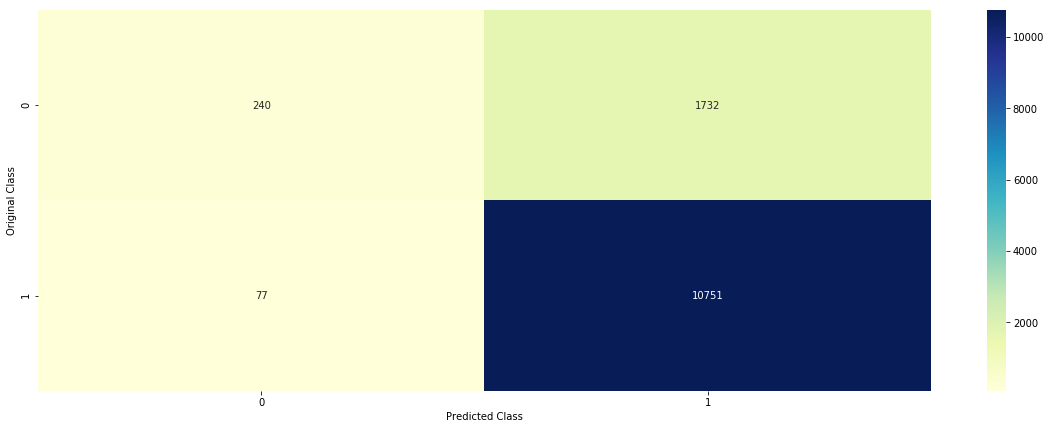

-------------------- Confusion matrix on test data --------------------


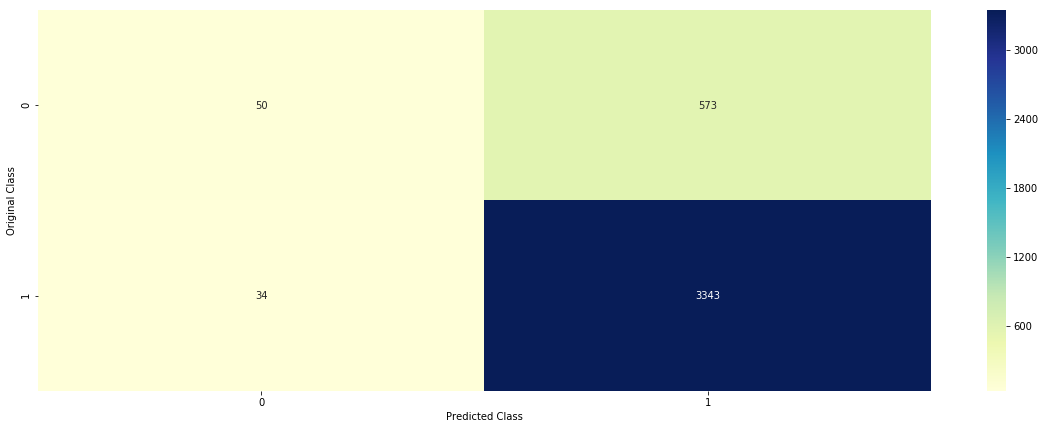

              precision    recall  f1-score   support

           0       0.60      0.08      0.14       623
           1       0.85      0.99      0.92      3377

   micro avg       0.85      0.85      0.85      4000
   macro avg       0.72      0.54      0.53      4000
weighted avg       0.81      0.85      0.80      4000



(0.84825, 0.858671875, 13)

In [47]:
best_knn_kdtree(x_train_bag_c,y_train_s,x_test_bag_c,y_test_s,x_cv_bag_c,y_cv_s,13)

we are getting 84.5 accuracy on test data

*Tf-Idf*

In [16]:
tfidf_words_con = TfidfVectorizer(max_features=2000,min_df=50)
x_train_tfidf_c = tfidf_words_con.fit_transform(x_train_s)
x_test_tfidf_c = tfidf_words_con.transform(x_test_s)
x_cv_tfidf_c= tfidf_words_con.transform(x_cv_s)
print('After vectorizing with 2000 features shape of x Train',x_train_tfidf_c.shape)
print('After vectorizing with 2000 features shape of x Test',x_test_tfidf_c.shape)
print('After vectorizing with 2000 features shape of x CV',x_cv_tfidf_c.shape)

After vectorizing with 2000 features shape of x Train (12800, 1309)
After vectorizing with 2000 features shape of x Test (4000, 1309)
After vectorizing with 2000 features shape of x CV (3200, 1309)


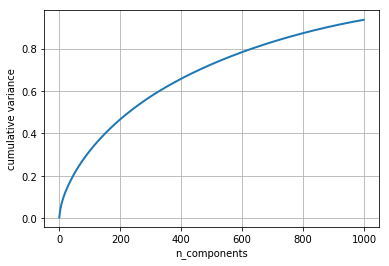

In [17]:
#converting to dense matrix using SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000)
svd.fit_transform(x_train_tfidf_c)
percentage_var_explained = svd.explained_variance_ratio_
cum_var_explained = np.cumsum(percentage_var_explained)
plt.figure(1,figsize=(6,4))
plt.clf()
plt.plot(cum_var_explained,linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('cumulative variance')
plt.show()

from above plot we can see taking n_componets we are keeping more than 80% information. so taking n_components as 650

In [18]:
svd_final = TruncatedSVD(n_components=650)
x_train_tfidf_c = svd_final.fit_transform(x_train_tfidf_c)

x_test_tfidf_c = svd_final.transform(x_test_tfidf_c)

x_cv_tfidf_c = svd_final.transform(x_cv_tfidf_c)

In [19]:
stand = StandardScaler()
x_train_tfidf_c = stand.fit_transform(x_train_tfidf_c)

x_test_tfidf_c = stand.transform(x_test_tfidf_c)

x_cv_tfidf_c = stand.transform(x_cv_tfidf_c)

For values of k =  1 The f1 score is: 0.9077695102958989
For values of k =  7 The f1 score is: 0.9170781542652818
For values of k =  13 The f1 score is: 0.9169638308711157
For values of k =  19 The f1 score is: 0.9167090754877014
For values of k =  25 The f1 score is: 0.9167655534836413
For values of k =  31 The f1 score is: 0.9164831441639845
For values of k =  37 The f1 score is: 0.9163279132791329


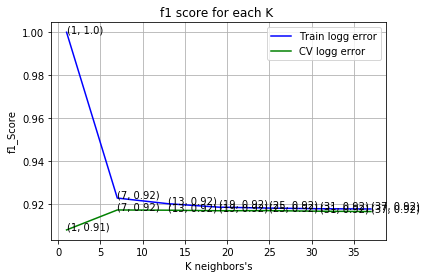

In [20]:
knn_kdtree(x_train_tfidf_c,y_train_s,x_test_tfidf_c,y_test_s,x_cv_tfidf_c,y_cv_s)

Taking K as 7

For values of best k =  7 The train f_1score is: 0.9226241255758403
For values of best k =  7 The test f1_score is: 0.9133707403859314
Accuracy on train data is  0.85828125
Accuracy on test data is  0.84175
-------------------- Confusion matrix on train data --------------------


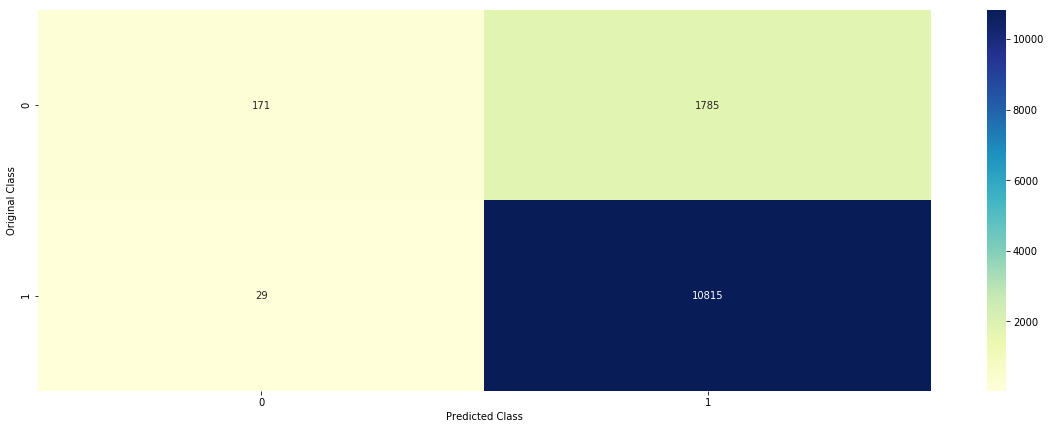

-------------------- Confusion matrix on test data --------------------


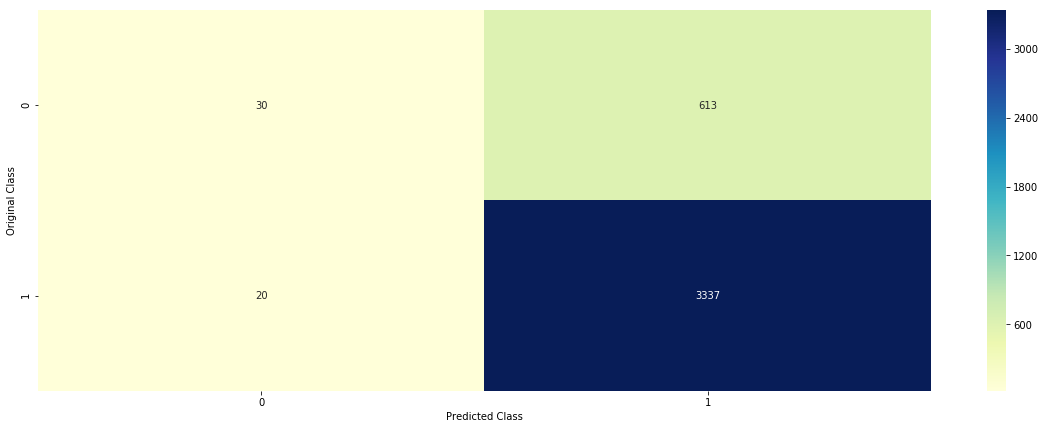

             precision    recall  f1-score   support

          0       0.60      0.05      0.09       643
          1       0.84      0.99      0.91      3357

avg / total       0.81      0.84      0.78      4000



(0.84175, 0.85828125, 7)

In [21]:
best_knn_kdtree(x_train_tfidf_c,y_train_s,x_test_tfidf_c,y_test_s,x_cv_tfidf_c,y_cv_s,7)

We are getting 84.15 accuracy on test data

In [ ]:
AvgW2V

In [26]:
list_sent_train_s=[]
for sent in x_train_s:
    filtered_sentence_s=[]
    sent = sent.decode('utf-8')
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence_s.append(cleaned_words.lower())
            else:
                continue 
    list_sent_train_s.append(filtered_sentence_s)

In [29]:
w2v_model_s = gensim.models.Word2Vec(list_sent_train_s,min_count=5,size=50, workers=4)

In [30]:
x_train_avgw2v_s= []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_sent_train_s: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_s.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    x_train_avgw2v_s.append(sent_vec)
print(len(x_train_avgw2v_s))
print(len(x_train_avgw2v_s[0]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


12800
50


In [31]:
list_sent_test_s=[]
for sent in x_test_s:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_test_s.append(filtered_sentence)
x_test_avgw2v_s= []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_sent_test_s: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    x_test_avgw2v_s.append(sent_vec)
print(len(x_test_avgw2v_s))
print(len(x_test_avgw2v_s[0]))

4000
50


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [32]:
list_sent_cv_s=[]
for sent in x_cv_s:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_cv_s.append(filtered_sentence)
x_cv_avgw2v_s= []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_sent_cv_s: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    x_cv_avgw2v_s.append(sent_vec)
print(len(x_cv_avgw2v_s))
print(len(x_cv_avgw2v_s[0]))

3200
50


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [34]:
x_train_avgw2v_s = np.nan_to_num(x_train_avgw2v_s)
x_test_avgw2v_s = np.nan_to_num(x_test_avgw2v_s)
x_cv_avgw2v_s = np.nan_to_num(x_cv_avgw2v_s)

For values of k =  1 The f1 score is: 0.9161727349703641
For values of k =  7 The f1 score is: 0.9161727349703641
For values of k =  13 The f1 score is: 0.9161727349703641
For values of k =  19 The f1 score is: 0.9161727349703641
For values of k =  25 The f1 score is: 0.9161727349703641
For values of k =  31 The f1 score is: 0.9161727349703641
For values of k =  37 The f1 score is: 0.9161727349703641


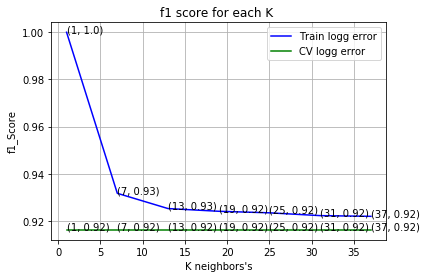

In [35]:
knn_kdtree(x_train_avgw2v_s,y_train_s,x_test_avgw2v_s,y_test_s,x_cv_avgw2v_s,y_cv_s)

taking k as 13

For values of best k =  13 The train f_1score is: 0.9252308092410386
For values of best k =  13 The test f1_score is: 0.9126002446649449
Accuracy on train data is  0.865234375
Accuracy on test data is  0.83925
-------------------- Confusion matrix on train data --------------------


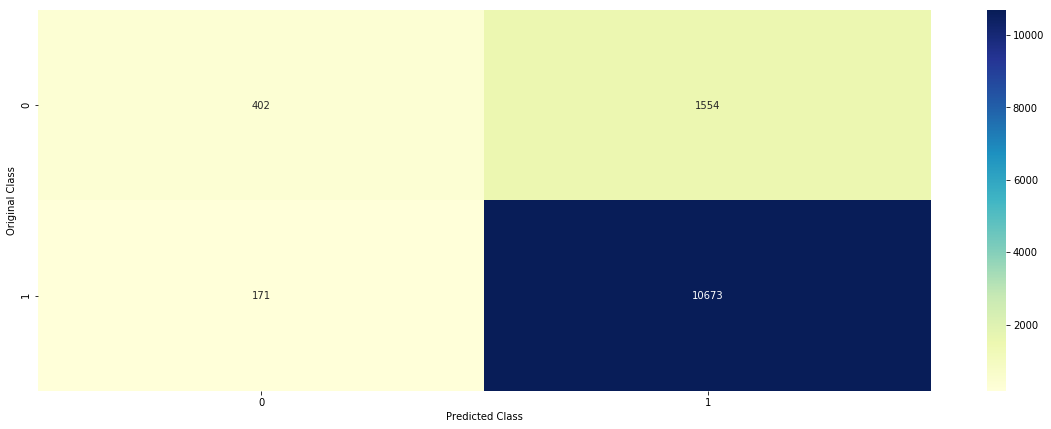

-------------------- Confusion matrix on test data --------------------


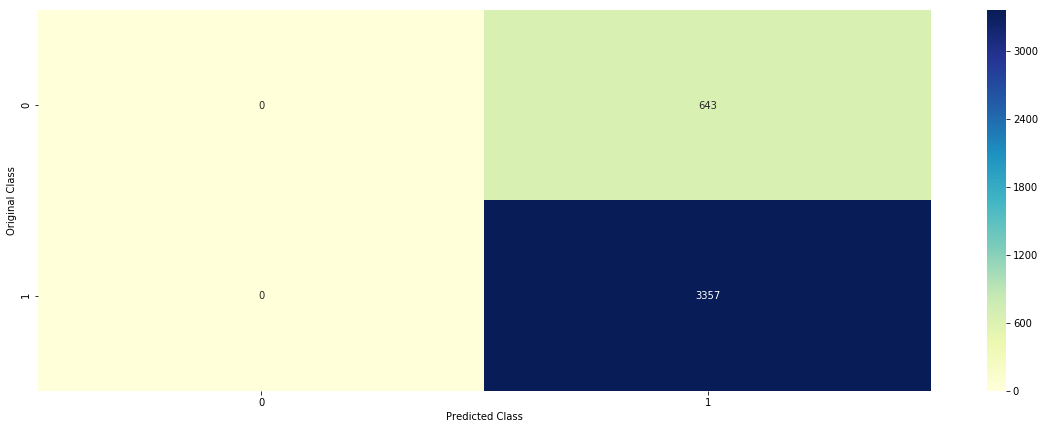

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       643
          1       0.84      1.00      0.91      3357

avg / total       0.70      0.84      0.77      4000



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.83925, 0.865234375, 13)

In [36]:
best_knn_kdtree(x_train_avgw2v_s,y_train_s,x_test_avgw2v_s,y_test_s,x_cv_avgw2v_s,y_cv_s,13)

there is some difference in test and train accuracy but not much

In [ ]:

Tf-idf W2Vec

In [37]:
tfidf_feats = tfidf_words_con.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_train_tfidfwv_s= []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_sent_train_s: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_s.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf_s[row, tfidf_feats_s.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    x_train_tfidfwv_s.append(sent_vec)
    row += 1
print('train shape',len(x_train_tfidfwv_s),len(x_train_tfidfwv_s[0]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


train shape 12800 50


In [38]:
x_test_tfidfwv_s= []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_sent_test_s: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_s.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf_t[row, tfidf_feats_s.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    x_test_tfidfwv_s.append(sent_vec)
    row += 1
print('test shape',len(x_test_tfidfwv_s),len(x_test_tfidfwv_s[0]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


test shape 4000 50


In [39]:
x_cv_tfidfwv_s= []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_sent_cv_s: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_s.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf_cv[row, tfidf_feats_s.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    x_cv_tfidfwv_s.append(sent_vec)
    row += 1
print('cv shape',len(x_cv_tfidfwv_s),len(x_cv_tfidfwv_s[0]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


cv shape 3200 50


In [40]:
x_train_tfidfwv_s = np.nan_to_num(x_train_tfidfwv_s)
x_test_tfidfwv_s = np.nan_to_num(x_test_tfidfwv_s)
x_cv_tfidfwv_s = np.nan_to_num(x_cv_tfidfwv_s)

For values of k =  1 The f1 score is: 0.9161727349703641
For values of k =  7 The f1 score is: 0.9161727349703641
For values of k =  13 The f1 score is: 0.9161727349703641
For values of k =  19 The f1 score is: 0.9161727349703641
For values of k =  25 The f1 score is: 0.9161727349703641
For values of k =  31 The f1 score is: 0.9161727349703641
For values of k =  37 The f1 score is: 0.9161727349703641


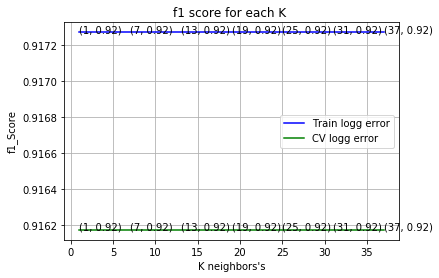

In [41]:
knn_kdtree(x_train_tfidfwv_s,y_train_s,x_test_tfidfwv_s,y_test_s,x_cv_tfidfwv_s,y_cv_s)

for all values of k we are getting same train and CV score .lets take k as 7

For values of best k =  7 The train f_1score is: 0.917272881069193
For values of best k =  7 The test f1_score is: 0.9126002446649449
Accuracy on train data is  0.8471875
Accuracy on test data is  0.83925
-------------------- Confusion matrix on train data --------------------


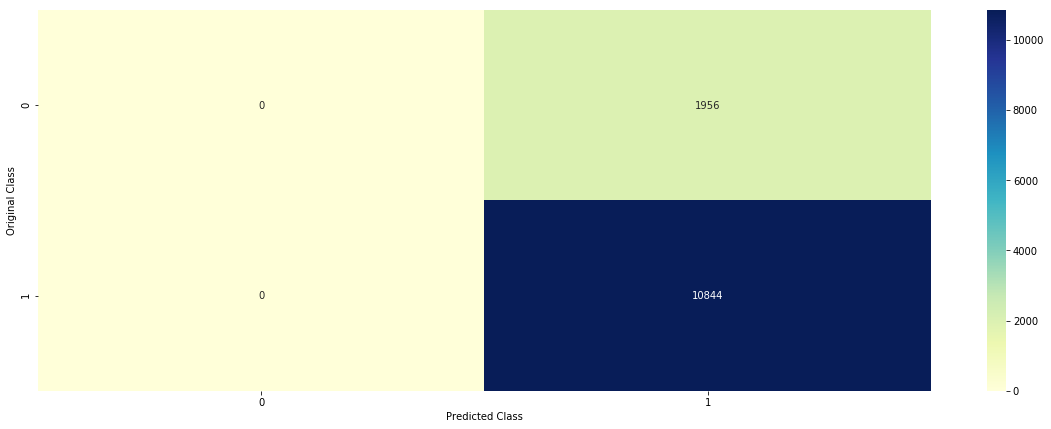

-------------------- Confusion matrix on test data --------------------


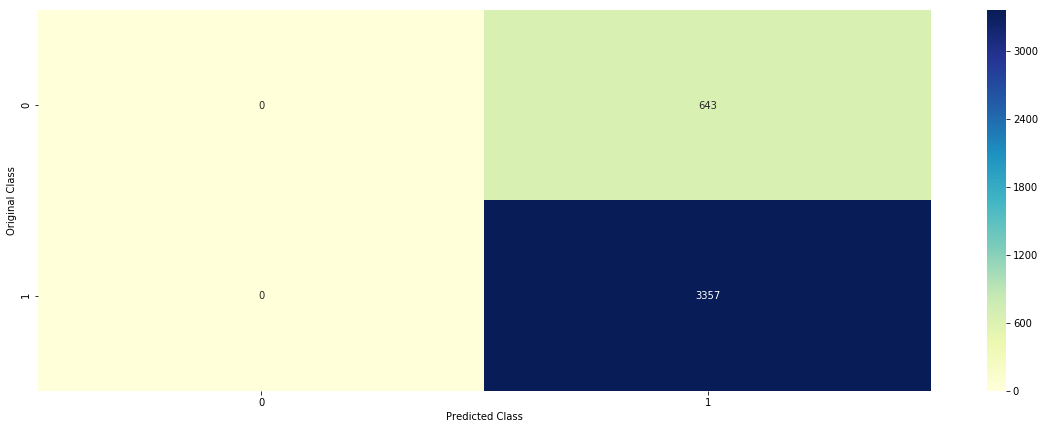

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       643
          1       0.84      1.00      0.91      3357

avg / total       0.70      0.84      0.77      4000



(0.83925, 0.8471875, 7)

In [42]:
best_knn_kdtree(x_train_tfidfwv_s,y_train_s,x_test_tfidfwv_s,y_test_s,x_cv_tfidfwv_s,y_cv_s,7)

In [ ]:
Again a dumb model

In [ ]:
Performance Table

<img  src = 'knn_perfromance.png'>

By looking above table we can say AVGW2V with brute is the best the model